In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import locale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests
from statsmodels.tsa.api import VAR


locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')
df = pd.read_csv('../data/df_analise.csv').set_index('Data')
df.index = pd.to_datetime(df.index, format='%b/%Y')
df = df.asfreq(pd.infer_freq(df.index))

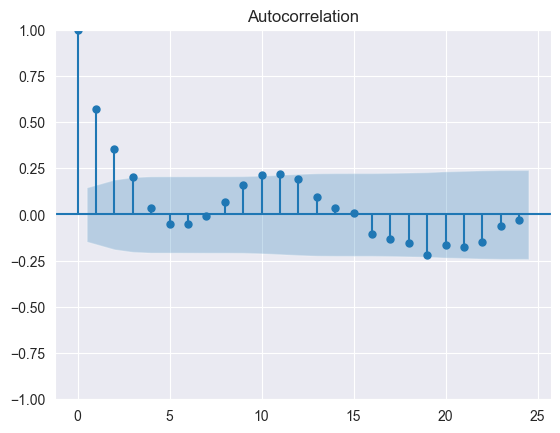

In [87]:
plot_acf(x=df['IPCA'], lags=24)
plt.show()

In [88]:
result_adfuller = adfuller(df['IPCA'], autolag='AIC')
print('Stationary: ' + str(result_adfuller[1] < 0.05))

Stationary: True


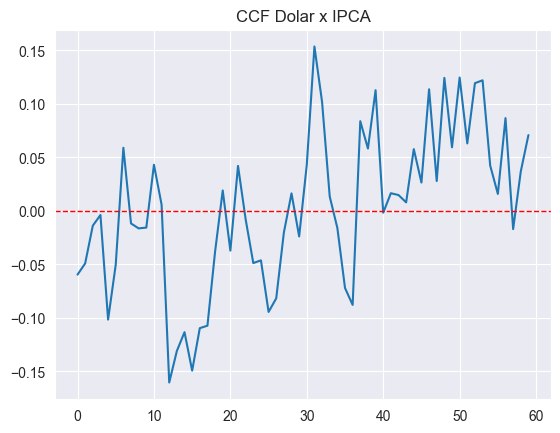

In [89]:
result_ccf = ccf(df['Dolar'], df['IPCA'], adjusted=True)[:60]
plt.plot(result_ccf, label='ccf')
plt.title('CCF Dolar x IPCA')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

In [90]:
model = VAR(df[['Dolar', 'IPCA']])
lag_order = model.select_order(maxlags=24)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,1.029,1.068,2.799,1.045
1,0.6964*,0.8142*,2.006*,0.7442*
2,0.7419,0.9382,2.100,0.8216
3,0.7896,1.064,2.203,0.9012
4,0.7224,1.076,2.060,0.8659
5,0.7715,1.203,2.164,0.9469
6,0.7690,1.279,2.159,0.9763
7,0.8040,1.393,2.237,1.043
8,0.8027,1.470,2.236,1.074
9,0.8352,1.581,2.311,1.138


In [91]:
result_var = model.fit(maxlags=3)
print(result_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 29, abr, 2025
Time:                     04:23:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.968889
Nobs:                     176.000    HQIC:                  0.818981
Log likelihood:          -548.535    FPE:                    2.04782
AIC:                     0.716691    Det(Omega_mle):         1.89415
--------------------------------------------------------------------
Results for equation Dolar
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            1.054406         0.677141            1.557           0.119
L1.Dolar        -0.043514         0.076857           -0.566           0.571
L1.IPCA         -0.774873         1.169859           -0.662           0.508
L2.D

In [92]:
cause = result_var.test_causality('IPCA', 'Dolar', kind='f')
cause.summary()

Test statistic,Critical value,p-value,df
0.3004,2.631,0.825,"(3, 338)"


In [93]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(result_var.resid, lags=[10], return_df=True)
print("Portmanteau Test Results:")
print(ljung_box_results)

ValueError: x is required to have ndim 1 but has ndim 2

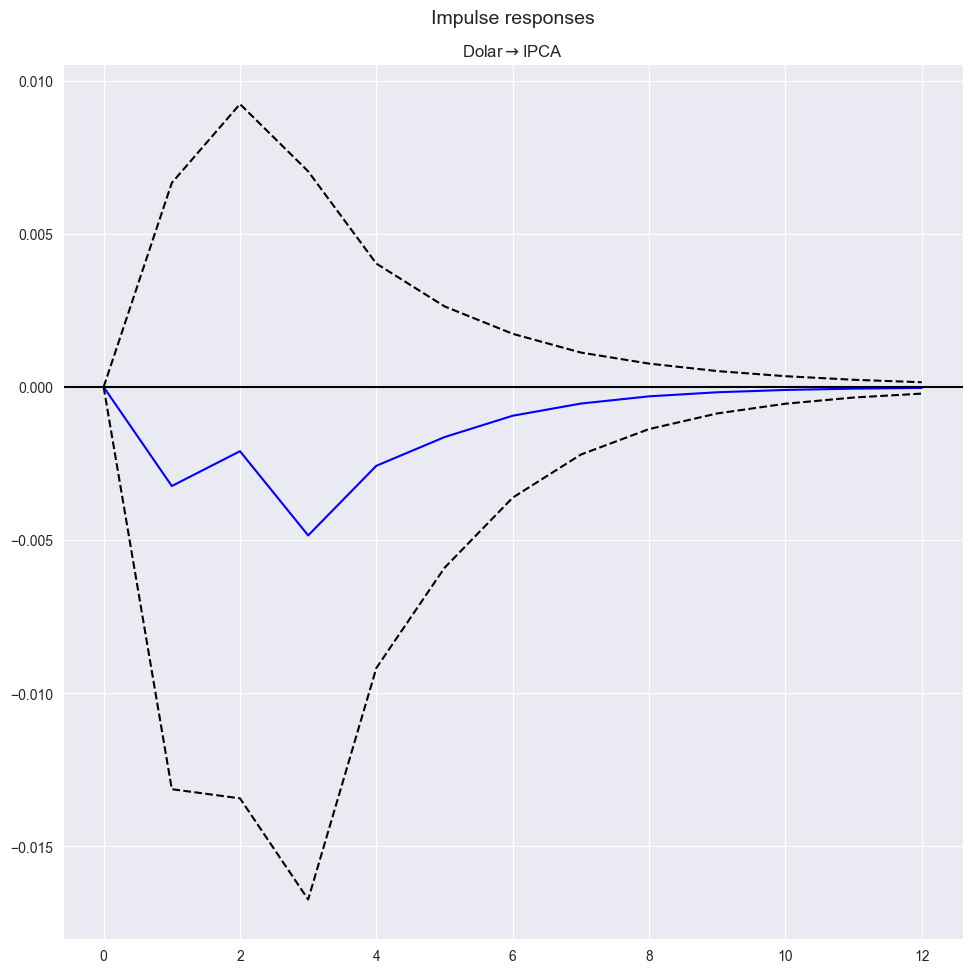

In [95]:
irf = result_var.irf(12)
irf.plot(impulse='Dolar', response='IPCA')
plt.show()

In [96]:
dolar_index = 0
x_index = 1

# Respostas de x a choques no Dólar
response_x_to_dolar = irf.orth_irfs [:, dolar_index, x_index]

for month, value in enumerate(response_x_to_dolar):
    print(f"Mês {month}: {value:.5f}")

Mês 0: 0.00000
Mês 1: -0.23295
Mês 2: -0.03879
Mês 3: -0.01438
Mês 4: -0.00644
Mês 5: -0.00293
Mês 6: -0.00132
Mês 7: -0.00068
Mês 8: -0.00035
Mês 9: -0.00019
Mês 10: -0.00010
Mês 11: -0.00006
Mês 12: -0.00003


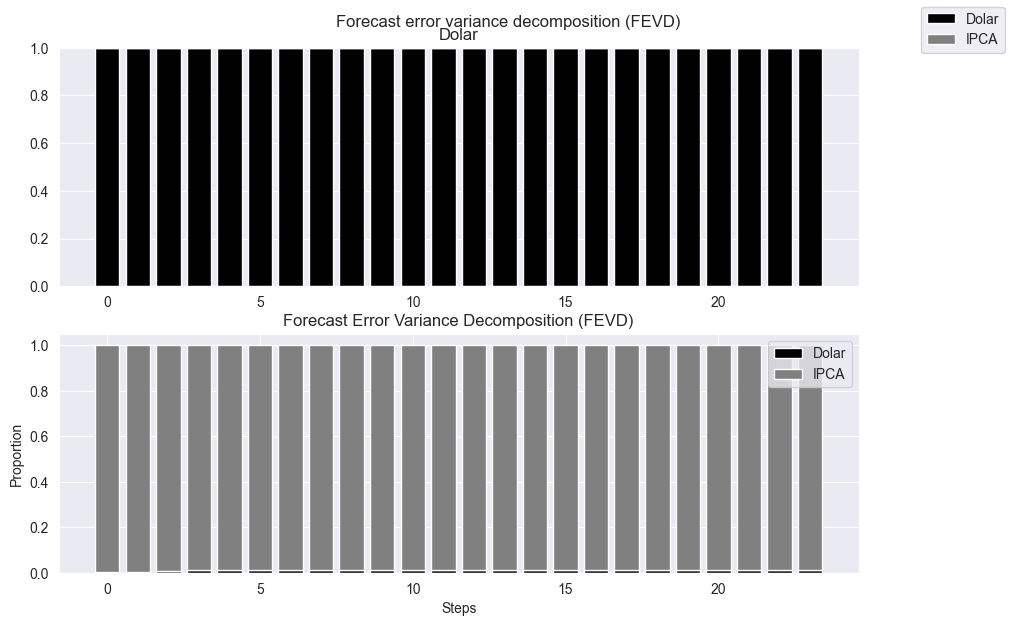

In [94]:
fevd = result_var.fevd(24)

# Plot the FEVD
fevd.plot(figsize=(10, 6))
plt.title("Forecast Error Variance Decomposition (FEVD)")
plt.xlabel("Steps")
plt.ylabel("Proportion")
plt.legend(loc='best')
plt.show()